In [4]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.model_selection import train_test_split
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.metrics import mean_absolute_error, mean_squared_error

import pywt
import h5py  # h5py 라이브러리 추가
import sys
sys.path.append('../../tool_code/python_tool_code/function/') # "~~/tool_code/plot/" (상대 경로)
sys.path.append('../../tool_code/python_tool_code/frequency_dataset_generation/')
from DataPlot import Data_Load_Plot, Result_Plot, Loss_Plot, Result_Plot_paper
from FFT_func import FFT

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# 데이터 load & plot
datapath= "C:/Users/stell/OneDrive/바탕 화면/real_data/"

# .mat 파일 로드
with h5py.File(datapath + 'PD_OpenLoop_ch12-13.mat', 'r') as f:
    fs = np.array(f['fs'])
    Contaminated_data = np.array(f['raw'])

with h5py.File(datapath + 'PD_rest(noStim)_ch12-13.mat', 'r') as f:
    Clean_data = np.array(f['raw'])  # 'variable_name'을 실제 변수명으로 변경

Contaminated_data = Contaminated_data.T
Clean_data = Clean_data.T
fs = int(fs.squeeze())

print(fs)
print(Contaminated_data.shape)
print(Clean_data.shape)

cuda:0
24414
(16, 7324200)
(16, 7324200)


Contaminated.shape: (7324200,)
Clean.shape: (7324200,)


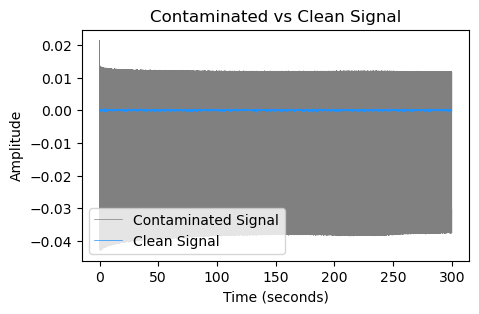

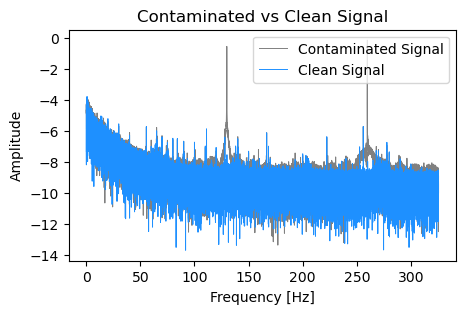

In [5]:
target_ch = 12
Contaminated = Contaminated_data[target_ch]
Clean = Clean_data[target_ch]
print("Contaminated.shape:", Contaminated.shape)
print("Clean.shape:", Clean.shape)

t = np.linspace(0, 300, num=fs*300) 
start_time = 0; # [sec]
end_time = 300; # [sec]
start_pts = int(start_time*fs)
end_pts = int(end_time*fs)

## Time domain Plotting ###
plt.figure(figsize=(5, 3))
plt.plot(t[start_pts:end_pts], Contaminated[start_pts:end_pts], label='Contaminated Signal', color='gray', alpha=1, linewidth=0.5)
plt.plot(t[start_pts:end_pts], Clean[start_pts:end_pts], label='Clean Signal', color='dodgerblue', alpha=1, linewidth=0.5)
plt.xlabel('Time (seconds)');plt.ylabel('Amplitude');plt.title('Contaminated vs Clean Signal')
plt.legend(prop={'size': 10}, loc='lower left')
plt.show()

## Frequency domain Plottig ###  
freqs, _, _, Contaminated_psd = FFT(Contaminated, fs, single_sided=True)
_, _, _, Clean_psd = FFT(Clean, fs, single_sided=True)

plt.figure(figsize=(5, 3))
plt.plot(freqs[1:fs*4], np.log10(Contaminated_psd[0][1:fs*4]), label='Contaminated Signal', color='gray', alpha=1, linewidth=0.7)
plt.plot(freqs[1:fs*4], np.log10(Clean_psd[0][1:fs*4]), label='Clean Signal', color='dodgerblue', alpha=1, linewidth=0.7)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude')
plt.title('Contaminated vs Clean Signal')
plt.legend()
plt.show()

Contaminated.shape: (1, 16)
Clean.shape: (1, 16)


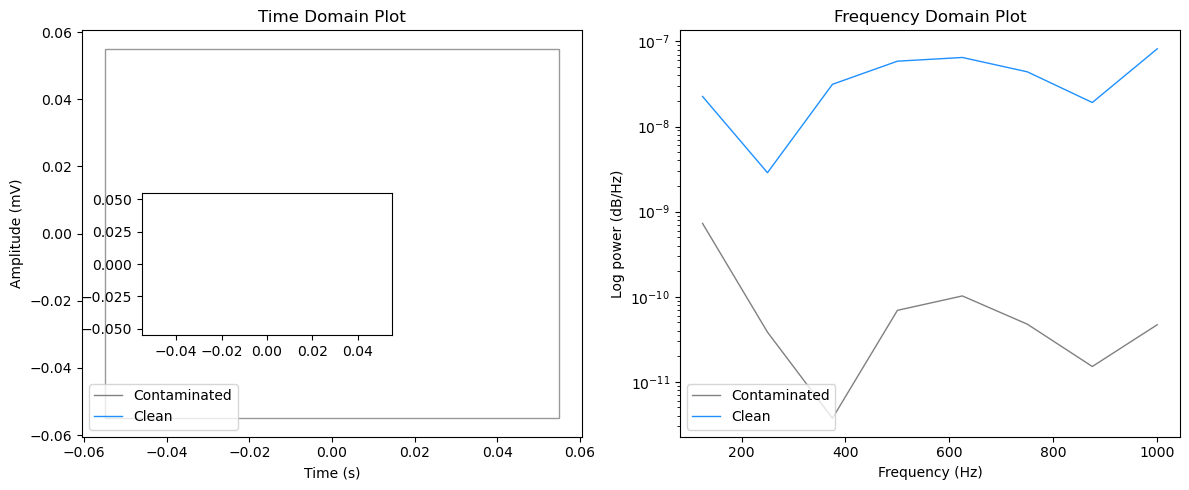

C:\Users\stell\AppData\Local\Temp\ipykernel_26660\1460039820.py:67: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, 2, 2)
C:\Users\stell\AppData\Local\Temp\ipykernel_26660\1460039820.py:78: UserWarning: tight_layout not applied: number of rows in subplot specifications must be multiples of one another.
  plt.tight_layout()


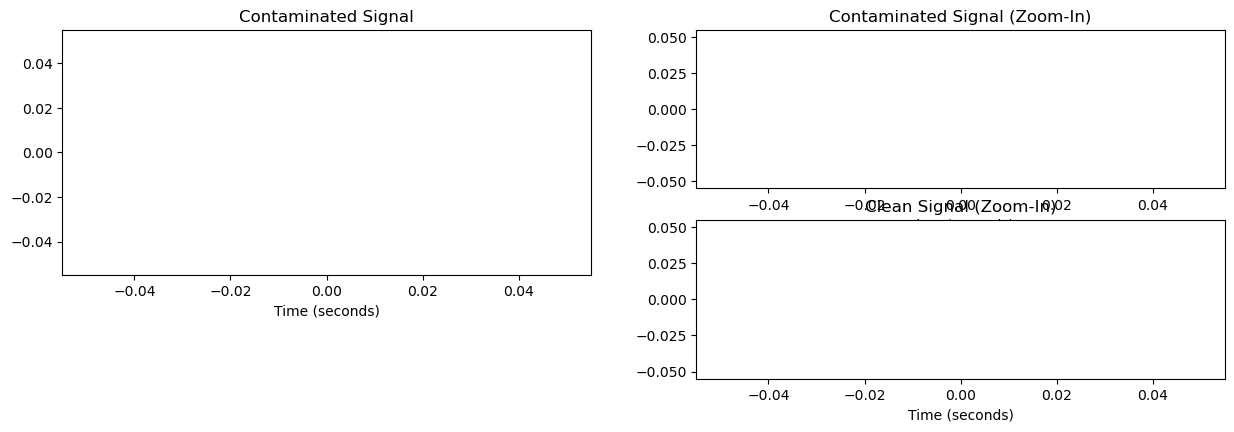

In [6]:
target_ch = 12
Contaminated = Contaminated_data[:, target_ch].reshape(1, -1)
Clean = Clean_data[:, target_ch].reshape(1, -1)
print("Contaminated.shape:", Contaminated.shape)
print("Clean.shape:", Clean.shape)

### Plot all in one ###

t = np.linspace(0, 2, num=4000) 
start_time = 0.75; # [sec]
end_time = 1.25; # [sec]
fs = 24414
start_pts = int(start_time*fs)
end_pts = int(end_time*fs)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

### Time domain Plotting ###

# main timeseries plot
axes[0].plot(t[start_pts:end_pts], Contaminated[0, start_pts:end_pts], label="Contaminated", color="gray", alpha=1, linewidth=1)
axes[0].plot(t[start_pts:end_pts], Clean[0, start_pts:end_pts], label="Clean", color='dodgerblue', alpha=1, linewidth=1)
axes[0].legend(prop={'size': 10}, loc='lower left')
axes[0].set_xlabel("Time (s)"); axes[0].set_ylabel("Amplitude (mV)")
axes[0].set_title("Time Domain Plot")

# zoom-in inset plot
inset_axis = axes[0].inset_axes((0.12, 0.25, 0.5, 0.35))
inset_axis.plot(t[start_pts : start_pts + 50], Contaminated[0, start_pts : start_pts + 50], color="gray")
inset_axis.plot(t[start_pts : start_pts + 50], Clean[0, start_pts : start_pts + 50], color='dodgerblue')
axes[0].indicate_inset_zoom(inset_axis, edgecolor="black", alpha=0.4)
inset_axis.patch.set_alpha(0.7)


### Frequency domain Plottig ###  

freqs, _, _, psd_Contaminated = FFT(Contaminated, fs=2000, single_sided=True)
_, _, _, psd_Clean = FFT(Clean, fs=2000, single_sided=True)

axes[1].semilogy(freqs[1:600], psd_Contaminated[0, 1:600], label="Contaminated", color='gray', alpha = 1, linewidth=1)
axes[1].semilogy(freqs[1:600], psd_Clean[0, 1:600], label="Clean", color='dodgerblue', alpha = 1, linewidth=1)
axes[1].legend(prop={'size': 10}, loc='lower left')
axes[1].set_xlabel("Frequency (Hz)"); axes[1].set_ylabel("Log power (dB/Hz)")
axes[1].set_title("Frequency Domain Plot")

fig.tight_layout()
plt.show()


### Plot [Contaminated / Artifact / Clean] ###

plt.figure(figsize=(15,7))

# Contaminated Signal
plt.subplot(2, 2, 1)
plt.plot(t[start_pts:end_pts], Contaminated[0][start_pts:end_pts], color='gray')
plt.xlabel("Time (seconds)")
plt.title('Contaminated Signal')

# Clean Signal
plt.subplot(2, 2, 2)
plt.plot(t[start_pts:end_pts], Clean[0][start_pts:end_pts], color='dodgerblue')
plt.xlabel("Time (seconds)")
plt.title('Clean Signal')

# Zoom-In Contaminated Signal
plt.subplot(3, 2, 2)
plt.plot(t[start_pts+400 : start_pts+600], Contaminated[0][start_pts+400 : start_pts+600], color='gray')
plt.xlabel("Time (seconds)")
plt.title('Contaminated Signal (Zoom-In)')

# Zoom-In Clean Signal
plt.subplot(3, 2, 4)
plt.plot(t[start_pts+400 : start_pts+600], Clean[0][start_pts+400 : start_pts+600], color='dodgerblue')
plt.xlabel("Time (seconds)")
plt.title('Clean Signal (Zoom-In)')

plt.tight_layout()
plt.show()
